In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm

Gaia query was done using the following ADQL:

```
SELECT *, phot_g_mean_mag+5*log10(parallax)-10 AS mg, 
sqrt(power(pmra,2)+power(pmdec,2)) AS pm
FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND phot_g_mean_mag < 11
AND phot_g_mean_mag+5*log10(parallax)-10 > 3
AND bp_rp > 0.5
AND bp_rp < 2.0
```

In [2]:
table = Table.read('bright_fgk-result.fits')
table['coords'] = SkyCoord(ra=table['ra'], dec=table['dec'])

In [3]:
sep_limit = 2. * u.pc
bp_limit = 0.5
rp_limit = 0.5

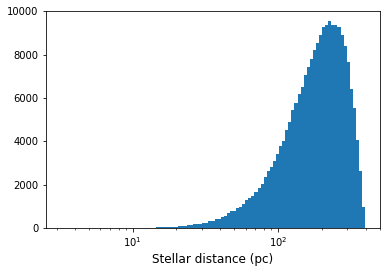

In [4]:
star_distances = ((table['parallax']).to(u.pc, equivalencies=u.parallax())).value
plt.hist(star_distances, bins=np.logspace(np.log10(star_distances.min()), np.log10(star_distances.max()), num=100))
plt.xscale('log')
plt.xlabel('Stellar distance (pc)',fontsize=12);

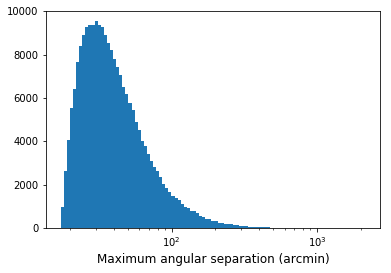

In [5]:
search_distances = sep_limit / (table['parallax']).to(u.pc, equivalencies=u.parallax()) * u.rad
search_distances = search_distances.to(u.arcmin).value
plt.hist(search_distances, bins=np.logspace(np.log10(search_distances.min()), np.log10(search_distances.max()), num=100))
plt.xscale('log')
plt.xlabel('Maximum angular separation (arcmin)',fontsize=12);

In [6]:
pairs = Table(names=('source_id1', 'source_id2', 'ra1', 'ra2', 'dec1', 'dec2',
                     'plx1', 'plx_error1', 'plx2', 'plx_error2', 
                     'pmra1', 'pmra_error1', 'pmra2', 'pmra_error2', 
                     'pmdec1', 'pmdec_error1', 'pmdec2', 'pmdec_error2',
                     'bp1', 'bp2', 'rp1', 'rp2', 'g1', 'g2', 'mg1', 'mg2',
                     'delta_distance', 'delta_distance_error', 'delta_pm', 'delta_pm_error',
                     'angsep'),
             dtype=('i8', 'i8', 'f8', 'f8', 'f8', 'f8',
                    'f8', 'f8', 'f8', 'f8', 
                    'f8', 'f8', 'f8', 'f8', 
                    'f8', 'f8', 'f8', 'f8', 
                    'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8',
                    'f8', 'f8', 'f8', 'f8', 'f8'))

In [7]:
def row_exists(pairs, s1, s2):
    mask1 = (pairs['source_id1'] == s1) & (pairs['source_id2'] == s2)
    mask2 = (pairs['source_id1'] == s2) & (pairs['source_id2'] == s1)
    if np.sum(mask1) > 0 or np.sum(mask2) > 0:
        return True
    else:
        return False

In [9]:
for star in tqdm(table):
    distance = (star['parallax'] * u.mas).to(u.pc, equivalencies=u.parallax()) # distance to star1
    nearby_stars = table[star['coords'].separation(table['coords']) <= sep_limit / distance * u.rad] 
    nearby_stars = nearby_stars[nearby_stars['source_id'] != star['source_id']] # eliminate self-match
    if len(nearby_stars) == 0: 
        #print('no nearby stars found!') 
        continue
    similar_mags = (np.abs(star['phot_bp_mean_mag'] - nearby_stars['phot_bp_mean_mag']) <= bp_limit) \
                    & (np.abs(star['phot_rp_mean_mag'] - nearby_stars['phot_rp_mean_mag']) <= rp_limit)
    nearby_stars = nearby_stars[similar_mags] # apply magnitude cuts
    if len(nearby_stars) == 0: 
        #print('all stars failed magnitude cut')
        continue
    d2 = nearby_stars['parallax'].to(u.pc, equivalencies=u.parallax()) # distances to star2s
    delta_d = np.abs(distance - d2) # distance difference
    delta_d_err = np.sqrt(distance**2/star['parallax_over_error']**2 + d2**2/nearby_stars['parallax_over_error']**2)
    similar_plx = delta_d <= 3. * delta_d_err + 2.*sep_limit
    nearby_stars = nearby_stars[similar_plx] # apply parallax cut
    if len(nearby_stars) == 0: 
        #print('all stars failed parallax cut') 
        continue
    delta_pm = np.sqrt((star['pmra'] - nearby_stars['pmra'])**2 + (star['pmdec'] - nearby_stars['pmdec'])**2)
    delta_pm_err = np.sqrt((star['pmra_error']**2 + nearby_stars['pmra_error']**2)*(star['pmra'] - nearby_stars['pmra'])**2
                           + (star['pmdec_error']**2 + nearby_stars['pmdec_error']**2)*(star['pmdec'] - nearby_stars['pmdec'])**2) \
                    * 1./delta_pm
    separation = star['coords'].separation(nearby_stars['coords']).to('arcsec')
    delta_pm_orbit = 0.44 * star['parallax']**1.5 / np.sqrt(separation/u.arcsec)  * u.mas / u.yr
    similar_pm = delta_pm <= 3. * delta_pm_err + delta_pm_orbit
    nearby_stars = nearby_stars[similar_pm] # apply parallax cut
    if len(nearby_stars) == 0: 
        #print('all stars failed proper motion cut') 
        continue
    for star2 in nearby_stars:
        if not row_exists(pairs, star['source_id'], star2['source_id']):
            pairs.add_row((star['source_id'], star2['source_id'], star['ra'], star2['ra'], star['dec'], star2['dec'],
                        star['parallax'], star['parallax_error'], star2['parallax'], star2['parallax_error'],
                        star['pmra'], star['pmra_error'], star2['pmra'], star2['pmra_error'],
                        star['pmdec'], star['pmdec_error'], star2['pmdec'], star2['pmdec_error'],
                        star['phot_bp_mean_mag'], star2['phot_bp_mean_mag'], star['phot_rp_mean_mag'], star2['phot_rp_mean_mag'],
                        star['phot_g_mean_mag'], star2['phot_g_mean_mag'], star['mg'], star2['mg'],
                        delta_d[similar_plx][similar_pm], delta_d_err[similar_plx][similar_pm], 
                        delta_pm[similar_pm], delta_pm_err[similar_pm], separation[similar_pm]))

100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


In [10]:
pairs

source_id1,source_id2,ra1,ra2,dec1,dec2,plx1,plx_error1,plx2,plx_error2,pmra1,pmra_error1,pmra2,pmra_error2,pmdec1,pmdec_error1,pmdec2,pmdec_error2,bp1,bp2,rp1,rp2,g1,g2,mg1,mg2,delta_distance,delta_distance_error,delta_pm,delta_pm_error,angsep
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4415158043064282368,4415158043064282112,229.15168005113216,229.15228085069663,-1.787051543021056,-1.7874746208390146,4.703044509426726,0.04733702679101735,4.745001918118632,0.048589146666247064,-3.390456021508674,0.09085012442630039,-4.876933406375842,0.07554838360054725,-46.639819930583535,0.07849177491535411,-47.43771040728203,0.07144506983048528,11.265878677368164,11.13231372833252,10.325861930847168,10.213040351867676,10.883574485778809,10.764222145080566,4.24546993033522,4.145404106692876,1.8801529345979304,3.039325396422191,1.6870815713911673,0.11557807636983639,2.644478357166207
3558078971047964800,3558078936688219776,168.83706942024506,168.83170187233424,-18.146900604417258,-18.147668912456858,43.58949028946906,0.04052725000971252,43.560771924948995,0.042754345821492644,143.89588156924742,0.06883824215888873,149.77230374857993,0.07130004122428538,-734.2289920759339,0.04488133194688903,-737.5854772293004,0.046327164151327496,10.192280769348145,10.27472972869873,8.488618850708008,8.546985626220703,9.353775024414062,9.419977188110352,7.550683977696423,7.615455023760376,0.015124545957132085,0.031026114509268413,6.7674463584516795,0.09181302246369616,18.569167672779713


In [ ]:
pairs.write('pairs.fits')